# Libraries

In [1]:
import random
import ray
import tensorflow as tf
import utils
from ray.rllib.algorithms.impala import Impala
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from environments.cartpole import CartPoleEnv

# Custom Model

In [2]:
class ImpalaCustomModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        inputs = tf.keras.layers.Input(shape=obs_space.shape, name='observations')
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model(inputs, [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        model_out, self._value_out = self.base_model(input_dict["obs"])
        return model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

# Default Model Train

2023-01-03 16:41:22,550	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-03 16:41:23,854	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.cartpole.CartPoleEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.cartpole.CartPoleEnv'>').build()` instead. This will raise an error in the future!
2023-01-03 16:41:23,855	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-01-03 16:41:23,882	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=16948) 2023-01-03 16:41:31,297	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is f

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 fc_2 (Dense)                   (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                                  
 fc_out (Dense)                 (None, 2)            514         ['fc_2[0][0]']                   
                                                                                              

2023-01-03 16:41:37,112	WARNING deprecation.py:47 -- DeprecationWarning: `concat_samples` has been deprecated. Use `concat_samples() from rllib.policy.sample_batch` instead. This will raise an error in the future!


Iteration: 0, Average Returns: 56.4
Iteration: 1, Average Returns: 149.0
Iteration: 2, Average Returns: 155.2
Iteration: 3, Average Returns: 153.6
Iteration: 4, Average Returns: 129.8
Iteration: 5, Average Returns: 205.4
Iteration: 6, Average Returns: 151.6
Iteration: 7, Average Returns: 101.2
Iteration: 8, Average Returns: 118.0
Iteration: 9, Average Returns: 56.6
Iteration: 10, Average Returns: 35.8
Iteration: 11, Average Returns: 106.2
Iteration: 12, Average Returns: 187.6
Iteration: 13, Average Returns: 166.2
Iteration: 14, Average Returns: 228.8
Iteration: 15, Average Returns: 238.0
Iteration: 16, Average Returns: 231.2
Iteration: 17, Average Returns: 275.4
Iteration: 18, Average Returns: 232.0
Iteration: 19, Average Returns: 157.4
Iteration: 20, Average Returns: 223.8
Iteration: 21, Average Returns: 373.6
Iteration: 22, Average Returns: 287.0
Iteration: 23, Average Returns: 47.2
Iteration: 24, Average Returns: 324.6
Iteration: 25, Average Returns: 324.2
Iteration: 26, Average Ret

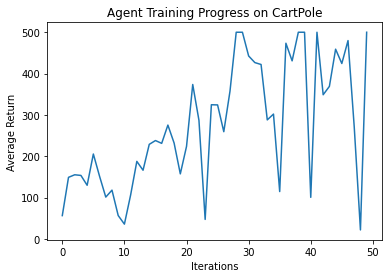

[56.4,
 149.0,
 155.2,
 153.6,
 129.8,
 205.4,
 151.6,
 101.2,
 118.0,
 56.6,
 35.8,
 106.2,
 187.6,
 166.2,
 228.8,
 238.0,
 231.2,
 275.4,
 232.0,
 157.4,
 223.8,
 373.6,
 287.0,
 47.2,
 324.6,
 324.2,
 259.4,
 357.6,
 500.0,
 500.0,
 442.6,
 426.6,
 422.0,
 288.0,
 302.0,
 114.6,
 473.4,
 430.8,
 500.0,
 500.0,
 100.6,
 500.0,
 348.8,
 369.0,
 459.0,
 424.4,
 479.8,
 271.0,
 21.8,
 500.0]

In [3]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
random.seed(0)
agent = Impala(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'model': {
        'vf_share_layers': True
    },
    'num_workers': 8,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'vtrace': True,
    'vtrace_clip_rho_threshold': 1.0,
    'vtrace_clip_pg_rho_threshold': 1.0,
    'vtrace_drop_last_ts': False,
    'replay_proportion': 0.1,
    'num_sgd_iter': 1,
    'entropy_coeff': 0.01,
    'vf_loss_coeff': 0.5,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))

# Custom Model Train

2023-01-03 16:57:30,848	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-03 16:57:32,298	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.cartpole.CartPoleEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.cartpole.CartPoleEnv'>').build()` instead. This will raise an error in the future!
(RolloutWorker pid=5428) 2023-01-03 16:57:40,005	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-01-03 16:57:44,171	INFO trainable.py:172 -- Trainable.setup took 11.867 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-01-03 16:57:44,172	WARNING util.py:66 -- Install gputil for GPU system monitoring.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 hidden_1 (Dense)               (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 hidden_2 (Dense)               (None, 256)          65792       ['hidden_1[0][0]']               
                                                                                                  
 policy_out (Dense)             (None, 2)            514         ['hidden_2[0][0]']               
                                                                                              

Exception in thread Thread-13:
Traceback (most recent call last):
  File "C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\ray\rllib\execution\learner_thread.py", line 74, in run
    self.step()
  File "C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\ray\rllib\execution\multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\ray\rllib\execution\minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\queue.py", line 179, in get
    raise Empty
_queue.Empty


Iteration: 2, Average Returns: 123.8
Iteration: 3, Average Returns: 43.8
Iteration: 4, Average Returns: 50.8
Iteration: 5, Average Returns: 165.0
Iteration: 6, Average Returns: 64.8
Iteration: 7, Average Returns: 123.6
Iteration: 8, Average Returns: 67.4
Iteration: 9, Average Returns: 128.2
Iteration: 10, Average Returns: 166.8
Iteration: 11, Average Returns: 189.2
Iteration: 12, Average Returns: 204.6
Iteration: 13, Average Returns: 196.6
Iteration: 14, Average Returns: 278.2
Iteration: 15, Average Returns: 152.6
Iteration: 16, Average Returns: 205.6
Iteration: 17, Average Returns: 102.8
Iteration: 18, Average Returns: 98.0
Iteration: 19, Average Returns: 261.0
Iteration: 20, Average Returns: 186.2
Iteration: 21, Average Returns: 256.8
Iteration: 22, Average Returns: 238.4
Iteration: 23, Average Returns: 204.2
Iteration: 24, Average Returns: 259.6
Iteration: 25, Average Returns: 159.8
Iteration: 26, Average Returns: 316.2
Iteration: 27, Average Returns: 399.2
Iteration: 28, Average Re

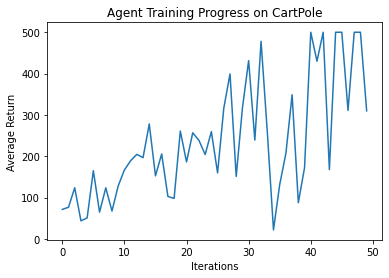

[71.4,
 76.6,
 123.8,
 43.8,
 50.8,
 165.0,
 64.8,
 123.6,
 67.4,
 128.2,
 166.8,
 189.2,
 204.6,
 196.6,
 278.2,
 152.6,
 205.6,
 102.8,
 98.0,
 261.0,
 186.2,
 256.8,
 238.4,
 204.2,
 259.6,
 159.8,
 316.2,
 399.2,
 151.2,
 316.6,
 431.4,
 239.2,
 478.0,
 260.0,
 21.8,
 131.4,
 207.2,
 348.8,
 87.6,
 172.2,
 500.0,
 430.0,
 500.0,
 167.8,
 500.0,
 500.0,
 311.0,
 500.0,
 500.0,
 309.8]

In [4]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
ModelCatalog.register_custom_model("impala_model", ImpalaCustomModel)
random.seed(0)
agent = Impala(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'model': {
        'vf_share_layers': True,
        'custom_model': 'impala_model',
        'custom_model_config': {}
    },
    'num_workers': 8,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'vtrace': True,
    'vtrace_clip_rho_threshold': 1.0,
    'vtrace_clip_pg_rho_threshold': 1.0,
    'vtrace_drop_last_ts': False,
    'replay_proportion': 0.1,
    'num_sgd_iter': 1,
    'entropy_coeff': 0.01,
    'vf_loss_coeff': 0.5,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))